<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/Desafio-NLP--Classificacao/Tweets_Covid_19_AnaliseSentimentos__LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimentos (classificação) de tweets relacionados a COVID-19, utilizando CountVectorizer, TF-IDF e Logistic Regression.

### Dataset: Coronavirus tweets NLP - Text Classification - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification


In [ ]:
!pip install contractions

In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')
%matplotlib inline
from PIL import Image

import nltk
import spacy
import re
import string
import unicodedata
import warnings

from sklearn import metrics
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#from nltk import bigrams
#from nltk import trigrams
from collections import Counter
from contractions import contractions_dict
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en --force

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_md -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/desafio 1/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregar as bases de treino e teste
df_train = pd.read_csv('Corona_NLP_train.csv', engine='python')
df_test = pd.read_csv('Corona_NLP_test.csv', engine='python')

In [ ]:
df_train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace=True)
df_test.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace=True)

In [ ]:
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
### Verificar valores nulos
print('df_train.OriginalTweet: ', (df_train.OriginalTweet.isna()).sum())
print('df_train.Sentiment: ',(df_train.Sentiment.isna()).sum())
print('df_test.OriginalTweet: ', (df_test.OriginalTweet.isna()).sum())
print('df_test.Sentiment: ',(df_test.Sentiment.isna()).sum())

df_train.OriginalTweet:  0
df_train.Sentiment:  0
df_test.OriginalTweet:  0
df_test.Sentiment:  0


## Análises estatísticas

### Número de tweets na base de treino e de teste

In [ ]:
print('Número de Tweets na base de treino: ', len(df_train))
print('Número de Tweets na base de test: ', len(df_test))

Número de Tweets na base de treino:  41157
Número de Tweets na base de test:  3798


### Distribuição de tweets por Classe

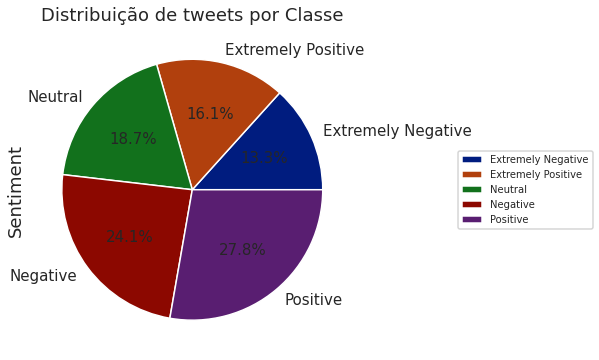

In [ ]:
df_distribution = df_train.Sentiment.value_counts()\
                            .to_frame()\
                            .sort_values('Sentiment')

df_distribution.plot.pie(y='Sentiment', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

In [ ]:
df_distribution.sort_values('Sentiment', ascending=False)

,Sentiment
Positive,11422
Negative,9917
Neutral,7713
Extremely Positive,6624
Extremely Negative,5481


### Tamanho dos tweets por classe

In [ ]:
df_train['text_length'] = df_train.OriginalTweet.apply(len)
df_train.head()

,OriginalTweet,Sentiment,text_length
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111
1,advice Talk to your neighbours family to excha...,Positive,237
2,Coronavirus Australia: Woolworths to give elde...,Positive,131
3,My food stock is not the only one which is emp...,Positive,306
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310


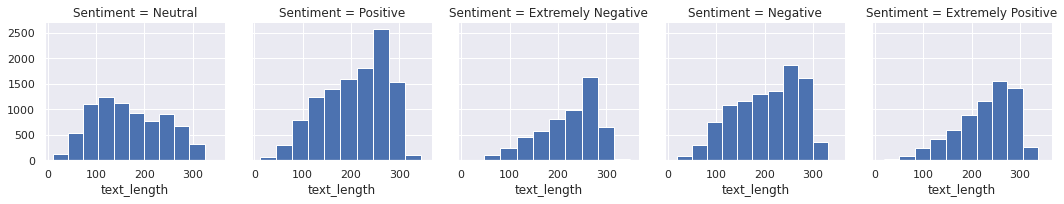

In [ ]:
sns.set(font_scale = 1)
g = sns.FacetGrid(df_train,col='Sentiment')
g.map(plt.hist,'text_length')
plt.show();

### Tamanho médio dos tweets por classe

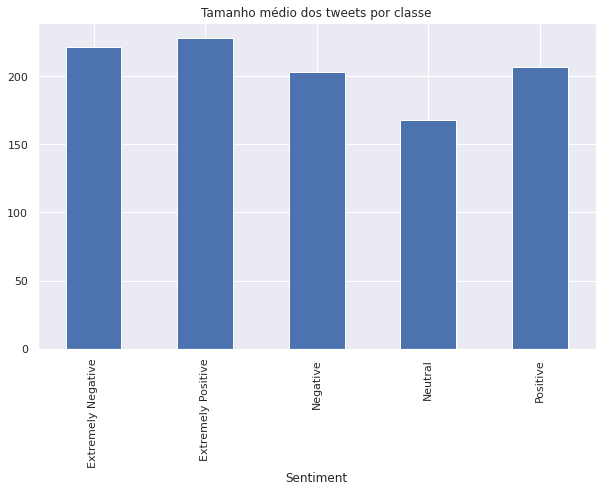

In [ ]:
df_group = df_train.groupby(['Sentiment'])['text_length'].agg('mean')
df_group.plot.bar(title='Tamanho médio dos tweets por classe', figsize=(10, 6))
plt.show();

In [ ]:
encoding = {'Extremely Negative': 'Negative',
            'Negative': 'Negative',
            'Neutral': 'Neutral',
            'Positive': 'Positive',
            'Extremely Positive': 'Positive'
           }

#labels = ['Negative', 'Neutral', 'Positive']
           
df_train["Sentiment"].replace(encoding, inplace=True)
df_test["Sentiment"].replace(encoding, inplace=True)

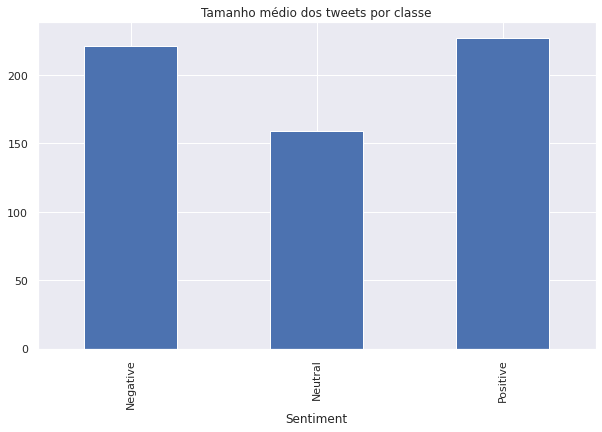

In [ ]:
df_group = df_train.groupby(['Sentiment'])['text_length'].agg('median')
df_group.plot.bar(title='Tamanho médio dos tweets por classe', figsize=(10, 6))
plt.show();

#### Distribuição da quantidade de palavras nos tweets

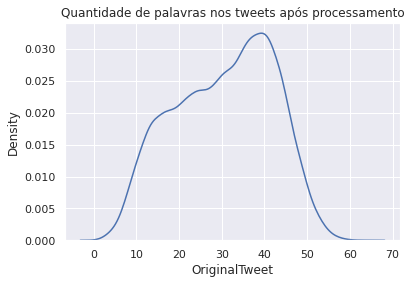

In [ ]:
totalNumWords = df_train.OriginalTweet.apply(lambda x: len(str(x).split()))
sns.distplot(totalNumWords, hist=False)
plt.title('Quantidade de palavras nos tweets após processamento')
plt.show();

## Pré-processamento do texto


In [ ]:
### Remove caracteres especiais e transforma em minúsculos
def remove_special_characters(text, remove_digits=False):
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)

  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_special_characters).str.lower()
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_special_characters).str.lower()

In [ ]:
### Remove acentos
def remove_accent(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text
df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_accent)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_accent)

In [ ]:
### Remove links
def strip_html_tags(text):
  text = re.sub(r"http[s]?://\S+", "", text)
  text = re.sub(r"\s+", " ", text)
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text()
  return stripped_text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(strip_html_tags)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(strip_html_tags)

In [ ]:
### Expande contrações
def expand_contractions(text, contraction_mapping=contractions_dict):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                    flags=re.IGNORECASE | re.DOTALL)

  def expand_match(contraction):
      match = contraction.group(0)
      first_char = match[0]
      expanded_contraction = contraction_mapping.get(match) \
          if contraction_mapping.get(match) \
          else contraction_mapping.get(match.lower())
      expanded_contraction = first_char + expanded_contraction[1:]
      return expanded_contraction
  
  try:
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
  except:
    return text
  return expanded_text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(expand_contractions)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(expand_contractions)

In [ ]:
### Lemetização
#nlp = spacy.load('en')

#def lemmatize(text):
#  text = nlp(text)
#  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#  return text

#df_train['OriginalTweet'] = df_train.OriginalTweet.map(lemmatize)
#df_test['OriginalTweet'] = df_test.OriginalTweet.map(lemmatize)

In [ ]:
### Remove stopwords
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.append('pic.twitter.com')
stopword_list.append('pic')
stopword_list.append('twitter')
stopword_list.append('http')
stopword_list.append('httpst')
stopword_list.append('amp')
#stopword_list.append('covid')
#stopword_list.append('covid19')
#stopword_list.append('covid_19')
#stopword_list.append('covid2019')
#stopword_list.append('coronavirus')
#stopword_list.append('covid')
#stopword_list.append('19')
stopword_list.append('100')
stopword_list.append('10')

df_train['OriginalTweet'] = df_train.OriginalTweet.map(word_tokenize)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(word_tokenize)

def remove_stopwords(text):
  tokens = text
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_stopwords)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_stopwords)

df_train.head()  

,OriginalTweet,Sentiment,text_length
0,menyrbie phil_gahan chrisitv coifz9fan2pa coxx...,Neutral,111
1,advice talk neighbours family exchange phone n...,Positive,237
2,coronavirus australia woolworths give elderly ...,Positive,131
3,food stock not one empty please dont panic eno...,Positive,306
4,ready go supermarket covid19 outbreak not im p...,Negative,310


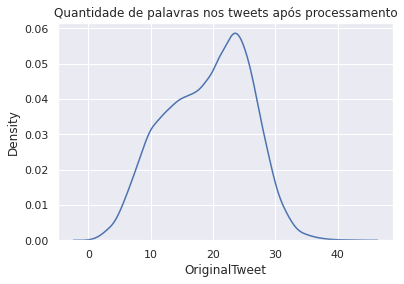

In [ ]:
totalNumWords = df_train.OriginalTweet.apply(lambda x: len(str(x).split()))
sns.distplot(totalNumWords, hist=False)
plt.title('Quantidade de palavras nos tweets após processamento')
plt.show();

## WordCloud

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_train.OriginalTweet)
corpus[:5]

['menyrbie', 'phil_gahan', 'chrisitv', 'coifz9fan2pa', 'coxx6ghgfzcc']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

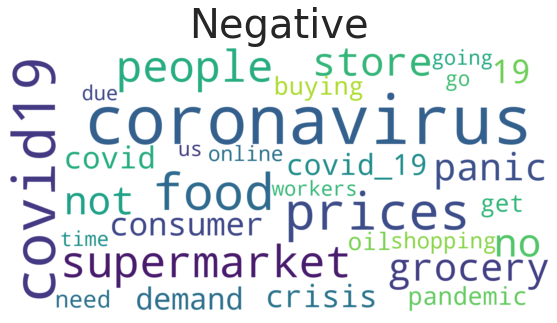

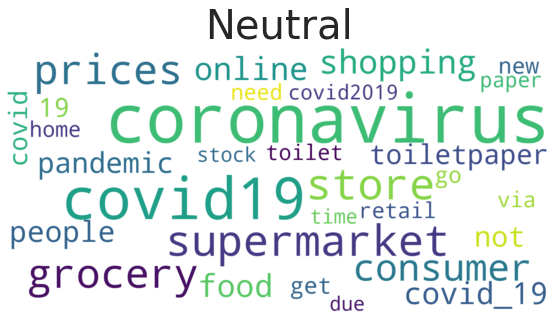

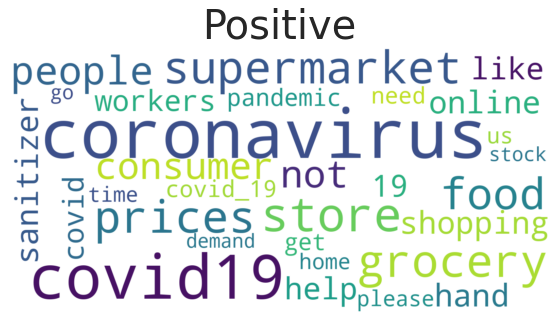

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    corpus = get_corpus(rows.OriginalTweet)
    counter = Counter(corpus)
    most_common = counter.most_common(30)
    most_common = dict(most_common)
  
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### Bigrams

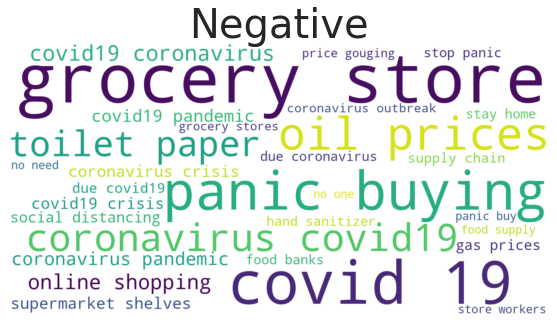

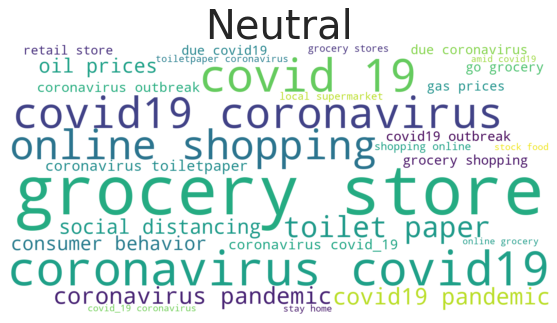

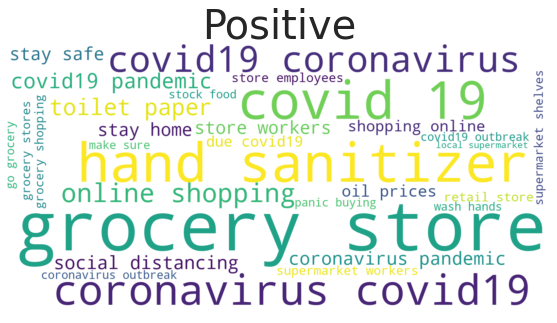

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,30,2)
    most_common = dict(most_common)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

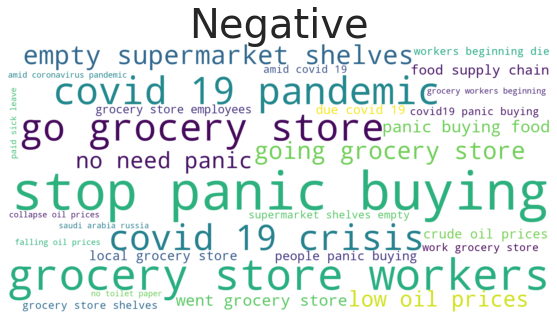

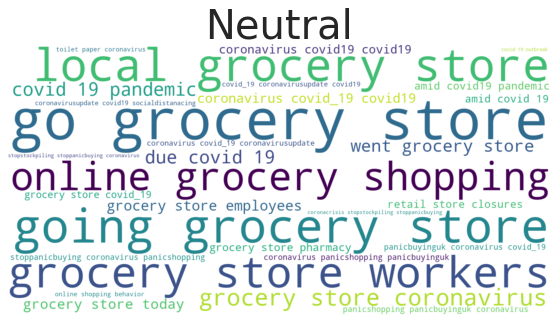

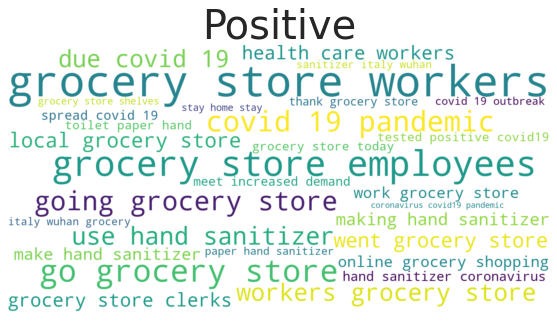

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,30,3)
    most_common = dict(most_common)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

## Análise de Sentimentos - Classificação dos Tweets

### Separa a base para input nos modelos

In [ ]:
X_train = df_train.OriginalTweet
X_test = df_test.OriginalTweet
y_train = df_train.Sentiment
y_test = df_test.Sentiment

### Funções Auxiliares

In [ ]:
def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions

In [ ]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)

    cm_frame = pd.DataFrame(cm, index=classes, columns=classes,)
    cm_frame.index.name = 'Actual'
    cm_frame.columns.name = 'Predicted'

    print(cm_frame)

In [ ]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

In [ ]:
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

In [ ]:
    
def get_metrics(true_labels, predicted_labels):
    
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))

  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4))

  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
     
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))
                                               
                                               
                        

### CountVectorizer

In [ ]:
cv = CountVectorizer()
cv_train_features = cv.fit_transform(X_train.ravel())
cv_test_features = cv.transform(X_test.ravel())

print('Shape das features de treino:', cv_train_features.shape,
      ' Shape das features de teste:', cv_test_features.shape)

Shape das features de treino: (41157, 83010)  Shape das features de teste: (3798, 83010)


In [ ]:
seed = 101 # fix random seed

#### Logistic Regression + CountVectorizer

In [ ]:
### Logistic Regression
logreg = LogisticRegression(solver = 'liblinear', random_state = seed)

logreg_cv_predictions = train_predict_model(classifier = logreg, 
                                                train_features = cv_train_features, train_labels = y_train,
                                                test_features = cv_test_features, test_labels = y_test)

display_model_performance_metrics(true_labels=y_test, predicted_labels=logreg_cv_predictions,
                                  classes = ['Negative', 'Neutral', 'Positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.8215
Precision: 0.8209
Recall: 0.8215
F1 Score: 0.8209

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83      1633
     Neutral       0.75      0.71      0.73       619
    Positive       0.83      0.86      0.84      1546

    accuracy                           0.82      3798
   macro avg       0.81      0.80      0.80      3798
weighted avg       0.82      0.82      0.82      3798


Prediction Confusion Matrix:
------------------------------
Predicted  Negative  Neutral  Positive
Actual                                
Negative       1352       86       195
Neutral         100      438        81
Positive        154       62      1330


### TF-IDF

In [ ]:
### TF-IDF
tv = TfidfVectorizer()
tv_train_features = tv.fit_transform(X_train.ravel())
tv_test_features = tv.transform(X_test.ravel())
print('Shape das features de treino:', tv_train_features.shape,
      ' Shape das features de teste:', tv_test_features.shape, '\n')

Shape das features de treino: (41157, 83010)  Shape das features de teste: (3798, 83010) 



#### Logistic Regression + TF-IDF

In [ ]:
### Logistic Regression
logreg = LogisticRegression(solver = 'liblinear', random_state = seed)

logreg_tv_predictions = train_predict_model(classifier = logreg, 
                                                train_features = tv_train_features, train_labels = y_train,
                                                test_features = tv_test_features, test_labels = y_test)

display_model_performance_metrics(true_labels=y_test, predicted_labels=logreg_tv_predictions,
                                  classes = ['Negative', 'Neutral', 'Positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.7838
Precision: 0.7837
Recall: 0.7838
F1 Score: 0.7801

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      1633
     Neutral       0.78      0.56      0.65       619
    Positive       0.78      0.84      0.81      1546

    accuracy                           0.78      3798
   macro avg       0.78      0.74      0.75      3798
weighted avg       0.78      0.78      0.78      3798


Prediction Confusion Matrix:
------------------------------
Predicted  Negative  Neutral  Positive
Actual                                
Negative       1328       60       245
Neutral         144      344       131
Positive        203       38      1305
